In [15]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import numpy as np
from scripts.utils import add_seasonality, split_data_frame, split_date, compile_and_fit, DataWindow

In [16]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 21
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [34]:
df = pd.read_csv("data/sp500/csv/AAPL.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

train_df, val_df, test_df = split_data_frame(df)

# Feature engineering
train_df = split_date(train_df)
# train_df = add_seasonality(train_df)
train_df.drop(columns=["Date"], inplace=True)

val_df = split_date(val_df)
# val_df = add_seasonality(val_df)
val_df.drop(columns=["Date"], inplace=True)

test_df = split_date(test_df)
# test_df = add_seasonality(test_df)
test_df.drop(columns=["Date"], inplace=True)


# Feature Scaling
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns]) 

In [35]:
train_df

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
0,0.008316,0.008145,0.063198,0.008185,0.008234,0.007513,0.0,1.000000,0.366667
1,0.007613,0.007510,0.023699,0.007494,0.007538,0.006879,0.0,1.000000,0.466667
2,0.006676,0.006585,0.014246,0.006571,0.006611,0.006032,0.0,1.000000,0.500000
3,0.006969,0.006816,0.011647,0.006859,0.006900,0.006296,0.0,1.000000,0.533333
4,0.007320,0.007163,0.009897,0.007205,0.007248,0.006614,0.0,1.000000,0.566667
...,...,...,...,...,...,...,...,...,...
7407,0.995540,0.985619,0.107383,0.998967,1.000000,1.000000,1.0,0.272727,0.733333
7408,1.000000,1.000000,0.064550,1.000000,0.995064,0.995066,1.0,0.272727,0.833333
7409,0.971254,0.982957,0.095578,0.982956,0.967379,0.967393,1.0,0.272727,0.866667
7410,0.955850,0.968095,0.102188,0.968790,0.965746,0.965761,1.0,0.272727,0.900000


In [36]:
cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, train_df=train_df, val_df=val_df, test_df=test_df, shift=21, label_columns=['Close'])

In [37]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
231/231 [==============================] - 1s 1ms/step - loss: 0.0052 - mean_absolute_error: 0.0304 - val_loss: 0.1394 - val_mean_absolute_error: 0.2935
Epoch 2/50
231/231 [==============================] - 0s 1ms/step - loss: 6.6942e-04 - mean_absolute_error: 0.0122 - val_loss: 0.1871 - val_mean_absolute_error: 0.3497
Epoch 3/50
231/231 [==============================] - 0s 1ms/step - loss: 6.7416e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0816 - val_mean_absolute_error: 0.2140
Epoch 4/50
231/231 [==============================] - 0s 1ms/step - loss: 6.7581e-04 - mean_absolute_error: 0.0119 - val_loss: 0.1864 - val_mean_absolute_error: 0.3486
Epoch 5/50
231/231 [==============================] - 0s 1ms/step - loss: 6.6294e-04 - mean_absolute_error: 0.0116 - val_loss: 0.1343 - val_mean_absolute_error: 0.2860
Epoch 6/50
65/65 [==============================] - 0s 517us/step - loss: 0.1633 - mean_absolute_error: 0.3203


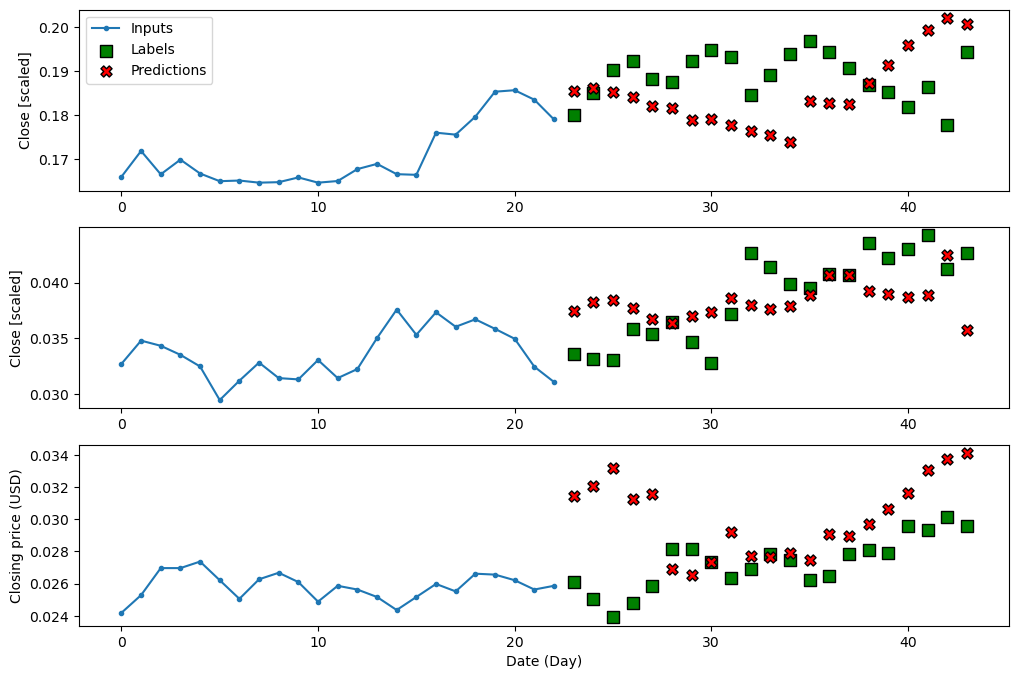

In [38]:
cnn_multi_window.plot(cnn_model)